***Note: this is the modularAllosteric.ipynb notebook. The
PDF version "Allosteric inhibition as a control actuator - modular approach: passive and active
feedback"
is available [here](modularAllosteric.pdf).***

# Introduction
Using the methods of control theory to examine and reexamine the behaviour of living systems is well-established
<cite data-cite="Cra47a">(Craik, 1947)</cite>
<cite data-cite="Wie61">(Weiner, 1961)</cite>
<cite data-cite="Bay66">(Bayliss, 1966)</cite>
<cite data-cite="Sav09">(Savageau, 1976)</cite>
<cite data-cite="JagFla03">(Jagacinski and Flach, 2003)</cite>
<cite data-cite="IglIng10">(Inglesias and Ingalls, 2010)</cite>
<cite data-cite="WelBulKalMasVer08">(Wellstead et al, 2008)</cite>
<cite data-cite="DriLeaDet15">(Drion et al, 2015)</cite>
<cite data-cite="Vec13">(Del Veccio, 2013)</cite>.
This notebook examines the enzyme-catalysed reaction as a control actuator and its behavior within a feedback loop controlling product concentration. The feedback mechanism used is *Allosteric inhibition* - see section 1.4.3
<cite data-cite="KeeSne09">(Keener and Sneyd, 2009)</cite>. 

- The notebook [fECR](https://github.com/gawthrop/BondGraphTools-Biomolecular/blob/master/fECR.ipynb) looks at an alternative feedback mechanism : competitive inhibition.
- As discussed in the notebook [Allosteric](https://github.com/gawthrop/BondGraphTools-Biomolecular/blob/master/Allosteric.ipynb), competitive inhibition is a special case of allosteric inhibition.
- As discussed in the notebook [fECR](fECR.pdf), the control methodology is based on 
    [Linearisation](https://github.com/gawthrop/BondGraphTools-Biomolecular/blob/master/Linearisation.ipynb).
- This notebook introduces a novel method based on *chemostats* for deducing the *feedback loop-gain* $L(s)$ from the bond graph describing the biomolecular system. $L(s)$ is a crucial component of feedback control analysis.
- The presence of *active* feedback via allosteric inhibition and *passive* feedback via the admittance of the reaction chain at the product is noted. The passive feedback has a stabilising effect.

## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import IPython.display as disp
import copy

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Modularity
import modularBondGraph as mbg

## Control systems package
import control as con

## Stoichiometry to BG
import stoichBondGraph as stbg

## Set quiet=False for verbose output
quiet = True

## Set slycot=True if slycot is installed (see control module)
slycot=True

## For reimporting: use imp.reload(module)
import importlib as imp

## Printing options
np.set_printoptions(precision=3)
fmt = '{:5.3f}'

## Allow output from within functions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Minreal (minimum realisation algorithm) tolerance
tol = 1e-2

## Chemostat EM and CM
chemostatEMCM = False

## Use fixed-length reaction chain (N_reac=3)
## Fixed = False allows arbitary length reaction chains using N_reac = int.
Fixed = True

## Derive stoichiometry from bond graph

In [2]:
def stoichiometry(abg,chemostats=[]):
    s = st.stoich(abg,quiet=quiet)
    sc = st.statify(s,chemostats=chemostats)    
    return s,sc

# Enzme catalysed reaction with allosteric inhibition

## Bond graph model

-  **Ce:A**: substrate
-  **Ce:B**: product
-  **Ce:B0**: product sink
-  **Ce:E**: enzyme
-  **Ce:C**: enzyme bound to A
-  **Ce:F** and **Ce:G**: species pumping the reaction
-  **Ce:B**: product
-  **Ce:EM**: enzyme bound to M
-  **Ce:CM**: complex C bound to M
-  Corresponding reactions are:

\begin{align}
\ch{A + E + F &<>[ r1 ] C }\\
\ch{C &<>[ r2 ] B + E + G }\\
\ch{B &<>[ r3 ] B0 }\\
\ch{CM &<>[ ra ] A + EM }\\
\ch{5 B + C &<>[ rc ] CM }\\
\ch{EM &<>[ re ] 5 B + E }
\end{align}

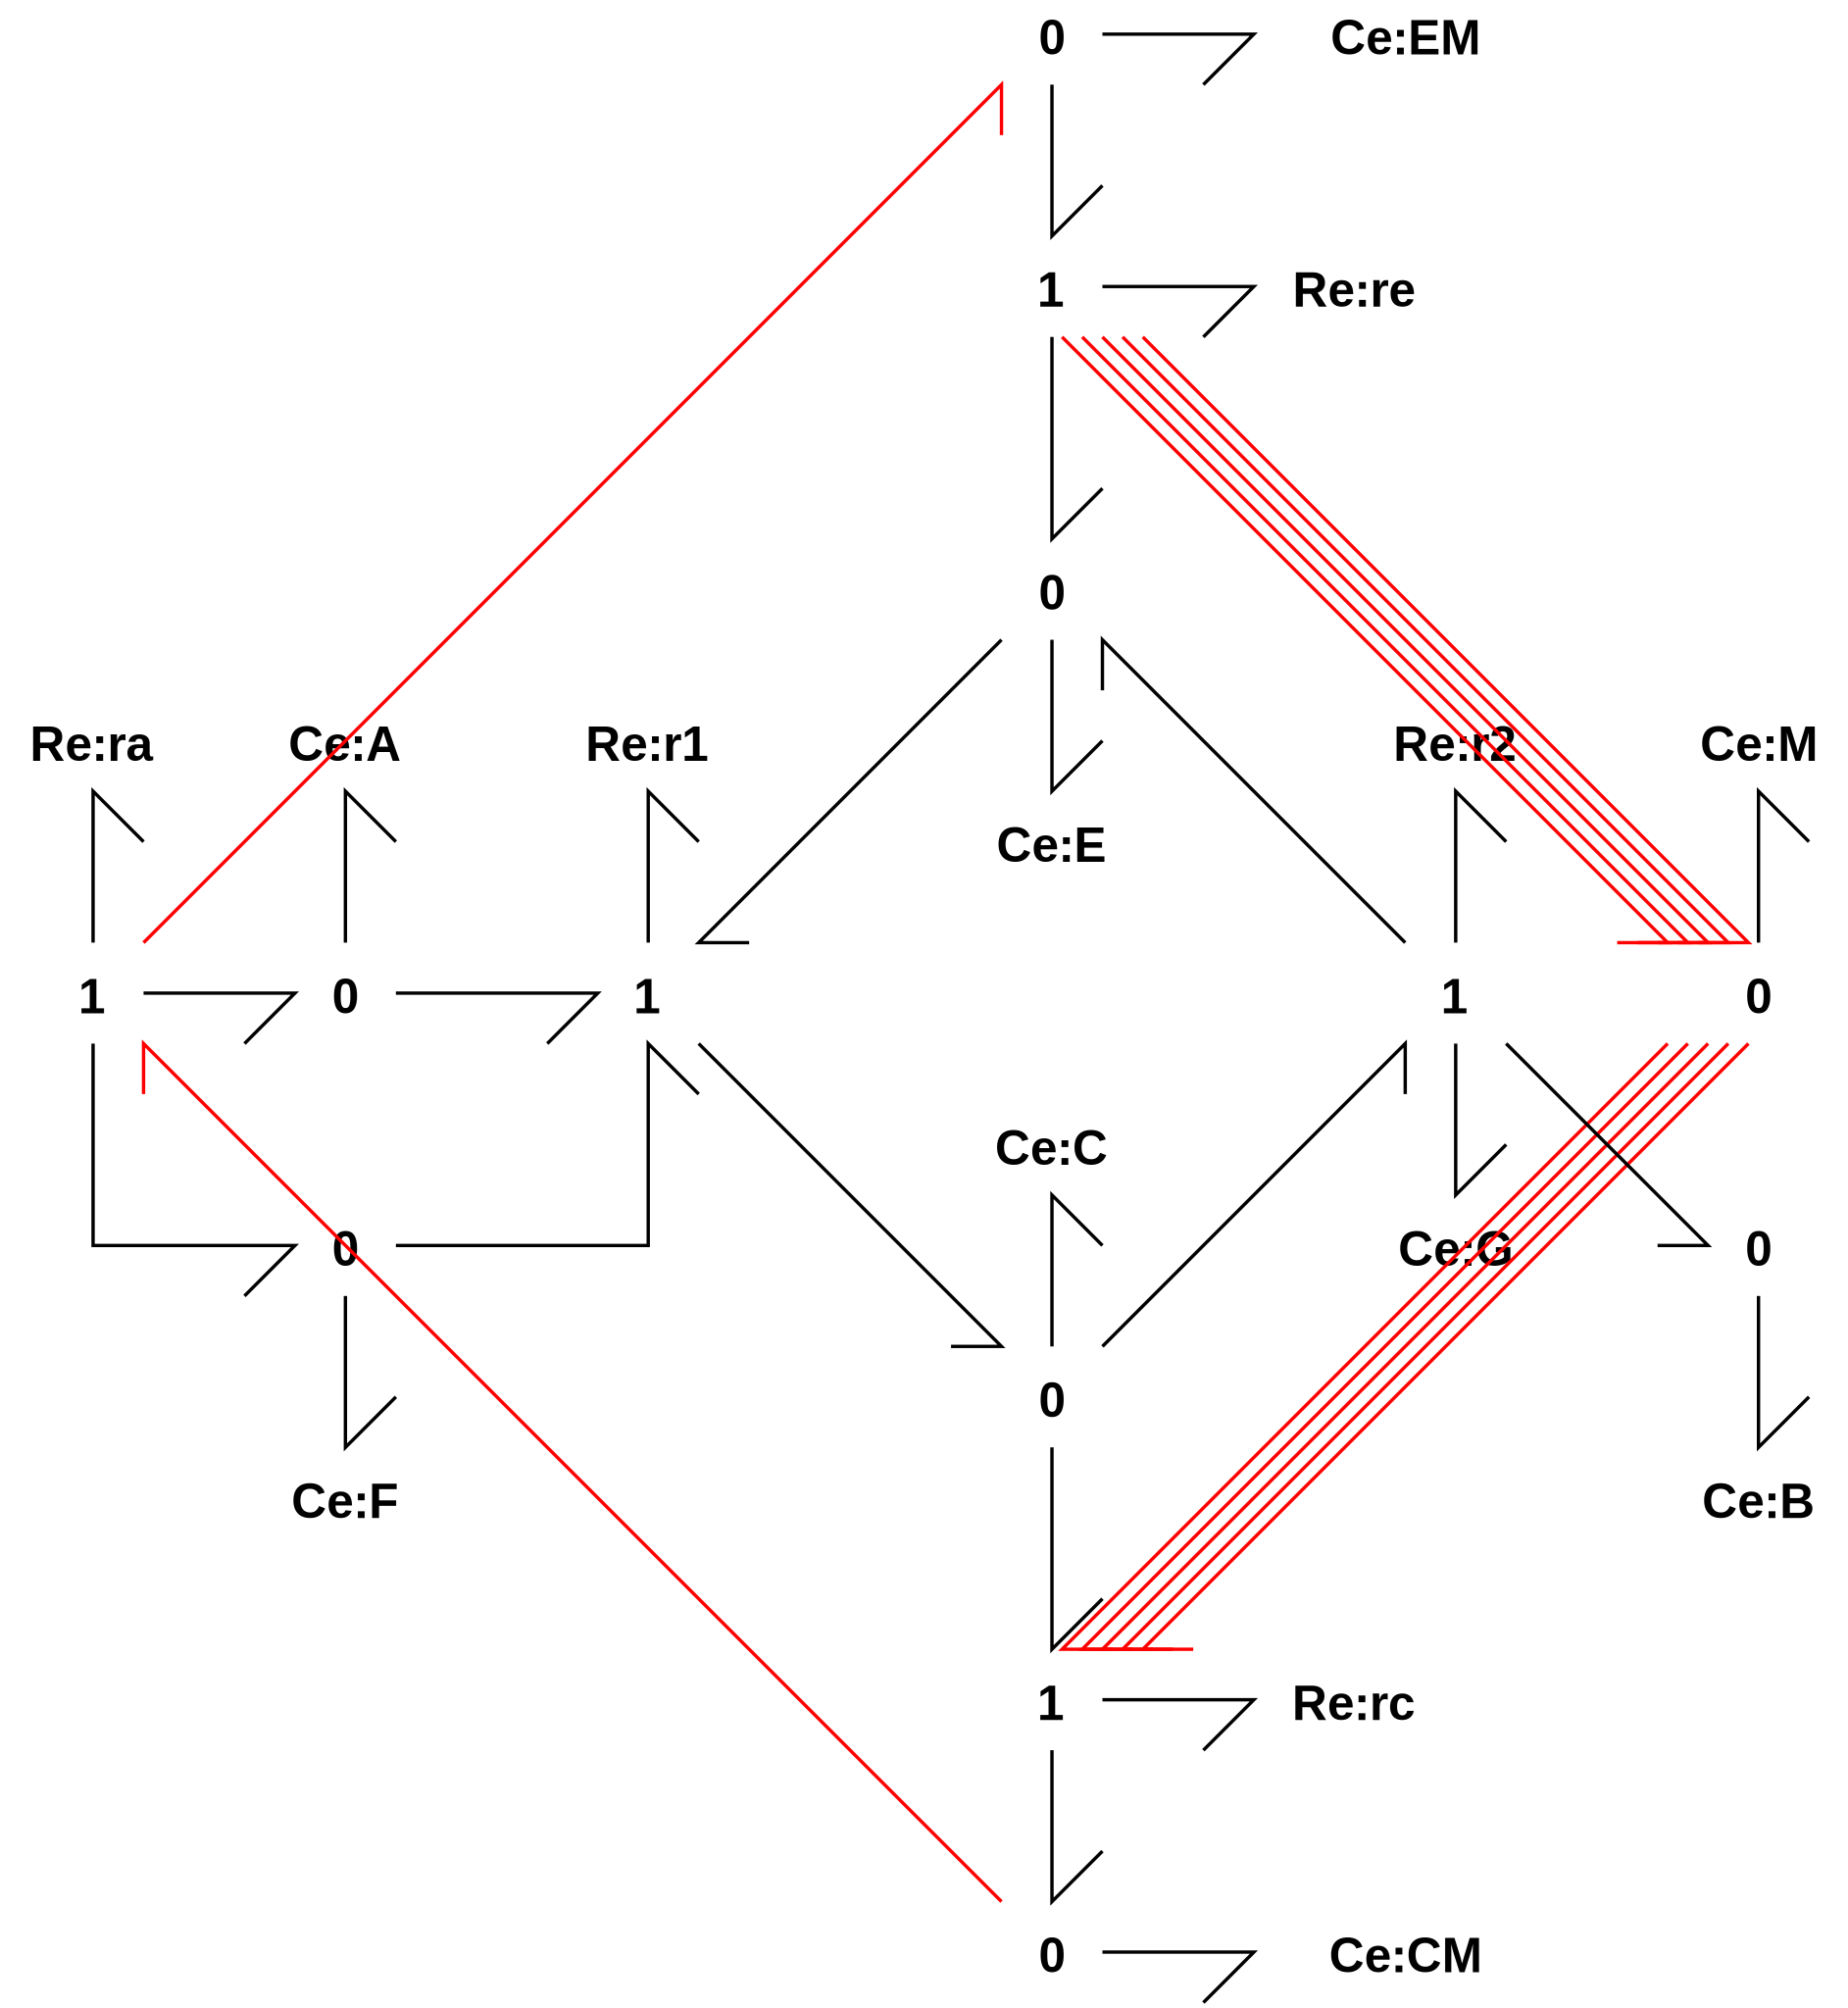

In [3]:
sbg.model('aiRE_abg.svg',quiet=quiet)
import aiRE_abg
#abg = aiRE_abg
disp.SVG('aiRE_abg.svg')

In [4]:
## Stoichiometry
chemostats=['A','M','F','G']
if chemostatEMCM:
    chemostats += ['EM','CM']

s,sc = stoichiometry(aiRE_abg.model(),chemostats=chemostats)

print('Reactions:')
disp.Latex(st.sprintrl(s,chemformula=True))
sp = st.path(s,sc)

Reactions:


<IPython.core.display.Latex object>

## Controlled system bond graph 

### Arbitrary length $N_{reac}$
This corresponds to the arbitary length chain when Fixed=False
It is the same as the fixed length chain when N_reac=3.

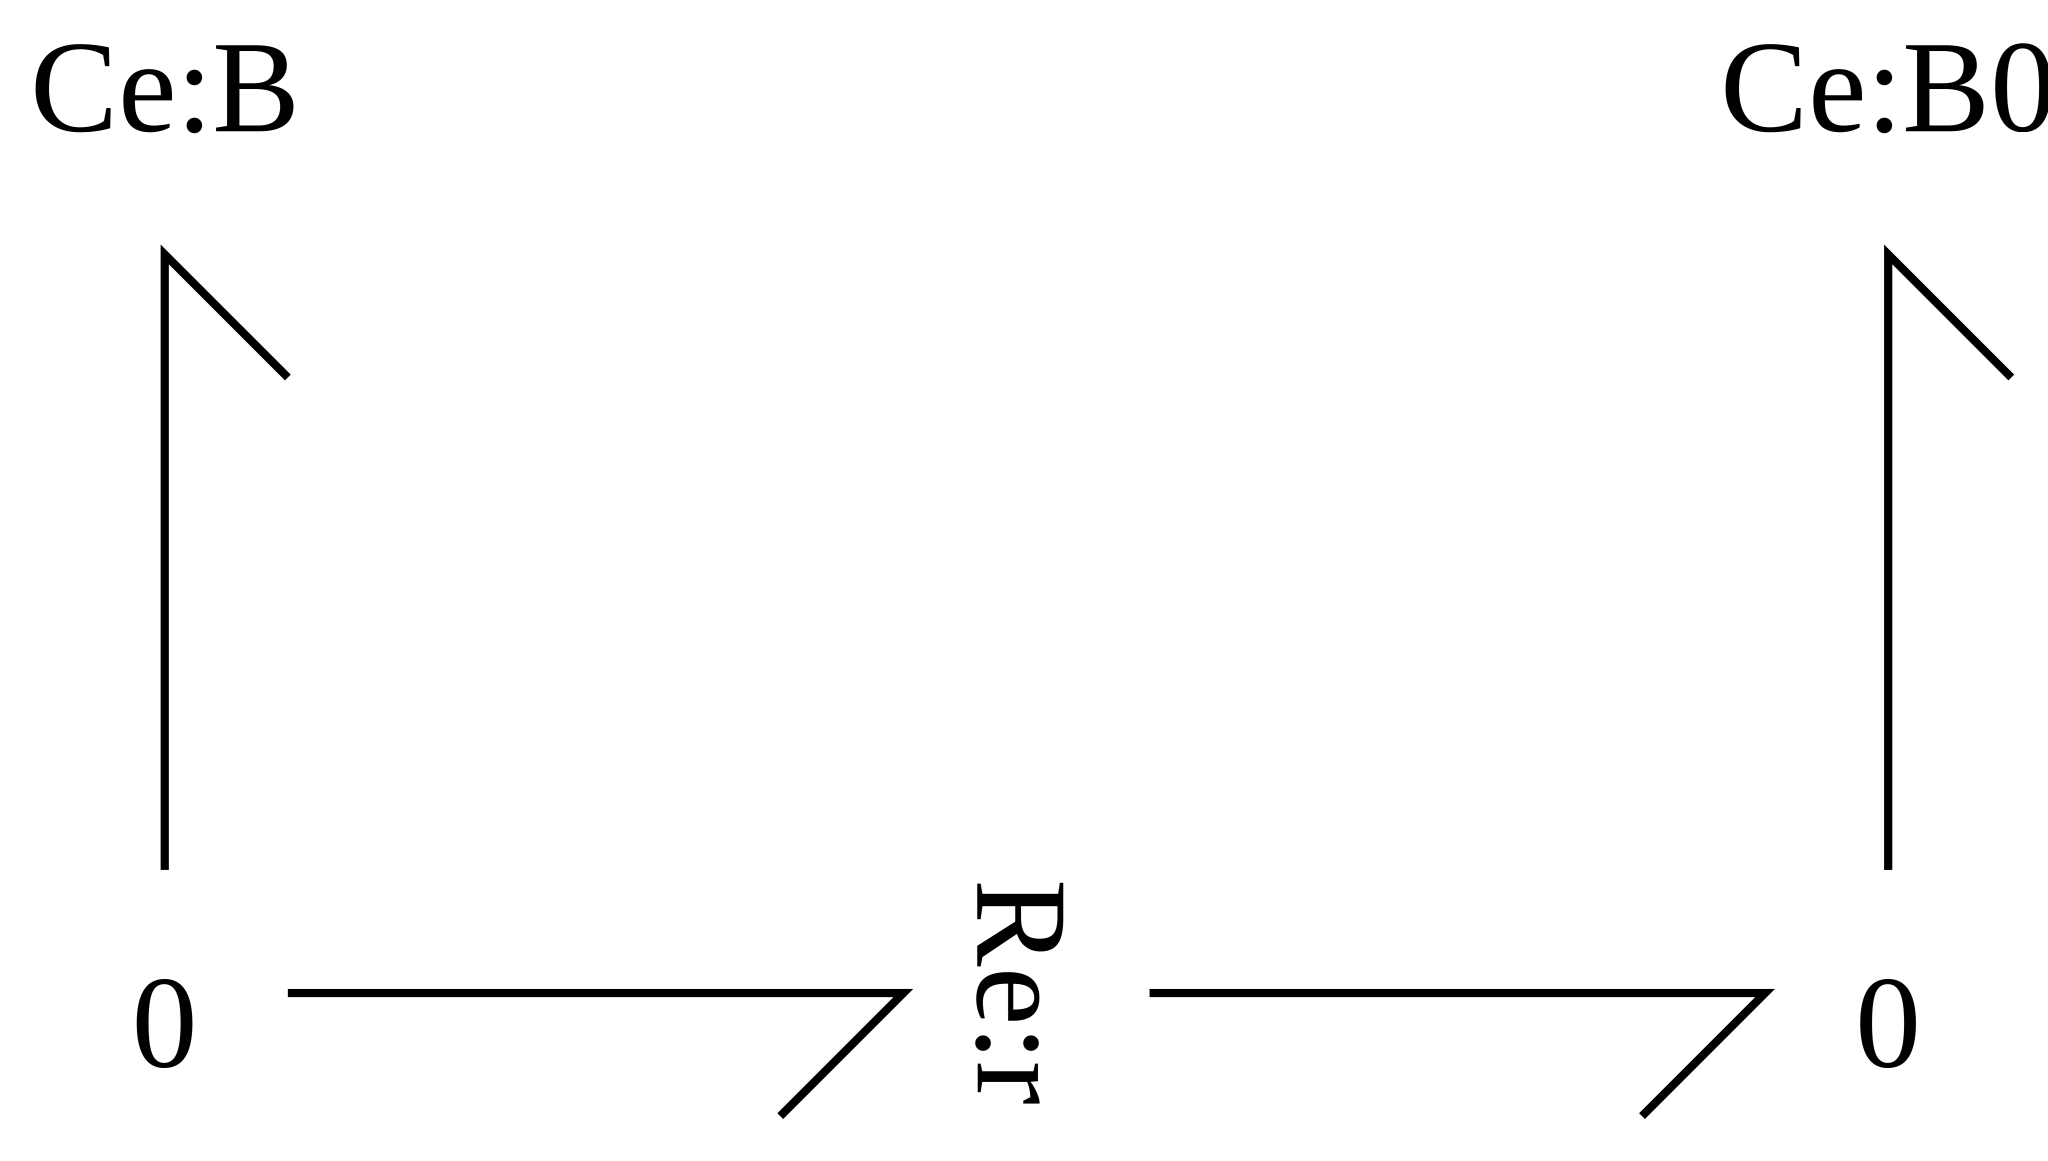

In [5]:
sbg.model('BB_abg.svg',quiet=quiet)
import BB_abg
disp.SVG('BB_abg.svg')

In [6]:
def CLBG(aiRE_abg,abg,N=1):

    if N is None:
        NBB = abg.model()
    else:
        ## Create chain
        NBB = mbg.chain(abg.model(),inport='B',outport='B0',N=N,quiet=quiet)
        if N>1:
            ## Rename penultimate state
            ISN1 = 'IS'+str(N-1)
            mbg.rename(NBB,{ISN1:'P'})
        else:
            mbg.rename(NBB,{'B':'P'})

    ## Create composite system
    aiRE = aiRE_abg.model()
    if N is 1:
        mbg.rename(aiRE,{'B':'P'})

    mbg.rename(aiRE,{'M':'P'})

    Allosteric = bgt.new(name='Allosteric') 
    Allosteric.add(aiRE,NBB)
    if N is 1:
        common = ['P']
    else:
        common = ['B','P']


    mbg.unify(Allosteric,common=common,quiet=quiet)
    
    return Allosteric

### Fixed length $N_{reac}=3$

This corresponds to the fixed-length chain when Fixed=True

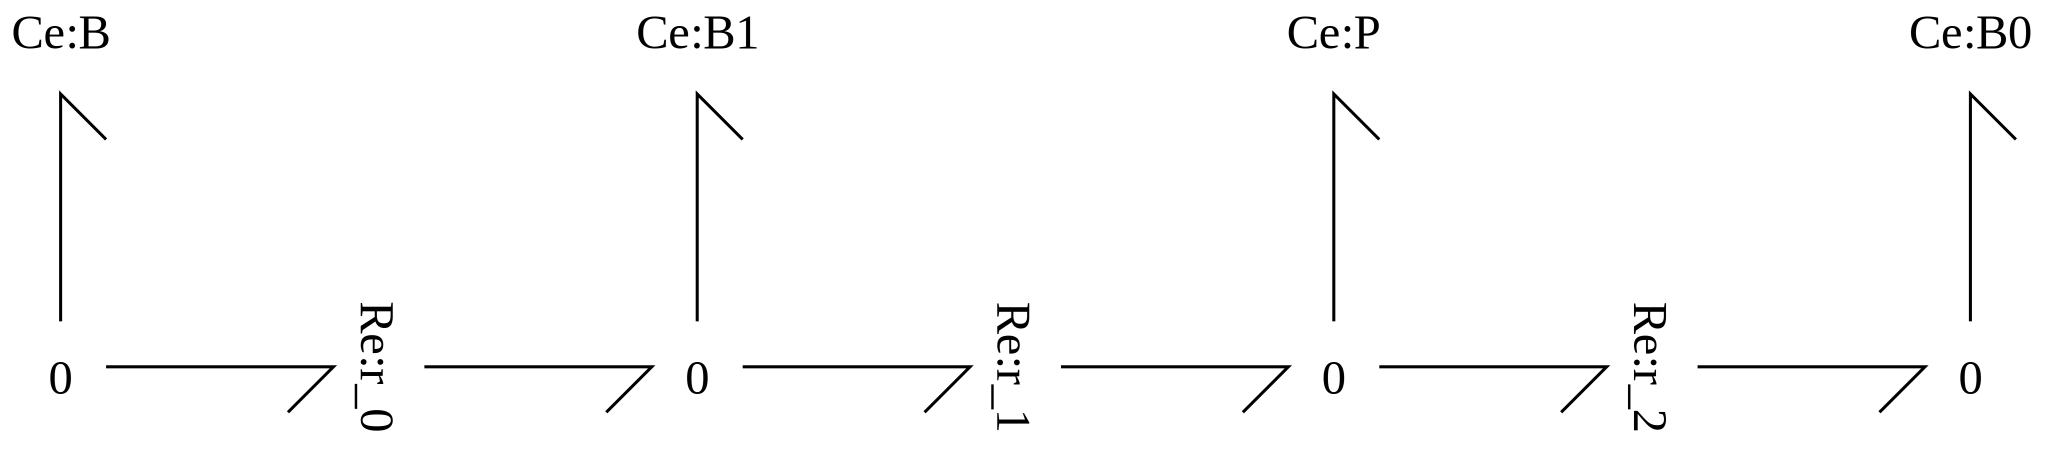

In [7]:
sbg.model('ReacChain_abg.svg',quiet=quiet)
import ReacChain_abg
disp.SVG('ReacChain_abg.svg')

## Stoichiometry and reactions

In [8]:
if Fixed:
    abg = ReacChain_abg
    N_reac = None
else:
    abg = BB_abg
    ## Number of reactions in the chain 
    N_reac = 3


## Create composite closed-loop system
Allosteric = CLBG(aiRE_abg,abg,N=N_reac)

## Stoichiometry
chemostats=['A','B0','F','G']
if chemostatEMCM:
    chemostats += ['EM','CM']
s,sc = stoichiometry(Allosteric,chemostats=chemostats)

print('Reactions:')
disp.Latex(st.sprintrl(s,chemformula=True))
sp = st.path(s,sc)
print('Pathway reactions:')
print(st.sprintp(sc))
disp.Latex(st.sprintrl(sp,chemformula=False))

Renaming components within aiRE
	Renaming M to P
Reactions:


<IPython.core.display.Latex object>

Pathway reactions:
2 pathways
0:  + r1 + ra + rc + re
1:  + r1 + r2 + r_0 + r_1 + r_2



<IPython.core.display.Latex object>

## Utility functions

In [9]:
def plotStep(tf,chemo,spec,T):
    
    t,y = con.step_response(tf,T=T)
    plt.plot(t,y)
    plt.grid()
    plt.xlabel('t')
    plt.ylabel('x_B')
    plt.title('Step response from '+chemo+' to '+spec)
    plt.show()
    
def showTF(tf):
    ## Show info
    print(tf)
    in_gain_X = con.dcgain(tf)
    print('\tgain:',fmt.format(in_gain_X))
    print('\tpoles:', con.pole(tf))
    print('\tzeros:', con.zero(tf))
    print('\n')

def extractTF(TF,chemo,spec):
    
    ## Index of product
    species = s['species']
    i_prod = species.index(spec)
    
    ## Index of input
    i = chemostats.index(chemo)
    
    ## Extract tf
    #print('\nTransfer function from','x_'+chemo,'to','x_'+spec)
    tf = con.minreal(TF[i_prod,i],tol=tol,verbose=True)
    
    #showTF(tf)
    
    return tf

def extractTFflow(TF,chemo,chemostats,reac):
    
    ## Index of reaction
    reaction = s['reaction']
    i_v = reaction.index(reac)
    
    ## Index of input
    i = chemostats.index(chemo)
    
    ## Extract tf
    #print('\nTransfer function from','x_'+chemo,'to','v_'+reac)
    tf = con.minreal(TF[i_v,i],tol=tol,verbose=True)
    
    #showTF(tf)
    
    return tf

# Closed-loop analysis
The function **ClosedLoop** derives the closed-loop properteis of the system from the bond graph model in the following steps:

- Extract stoichiometry
- Simulate the system to give a steady state
- linearise the closed-loop system about this steady state to give:
   - the multivariable transfer function relating chemostats to species states
   - the multivariable transfer function relating chemostats to reaction flows
- extract the scalar transfer functions relating the 'disturbance' $x_{B0}$ to
    - the product state $x_P$
    - the 'actuator' flow $v_{r2}$

In [10]:
def ClosedLoop(abg,chemostats,parameter,X0,t_ss,t_step,quiet=False):
    ## Analyse the system
    
    cabg = copy.copy(abg)
    
    ## Stoichiometry
    s,sc = stoichiometry(cabg,chemostats=chemostats)
    
    print('Closed-loop. Order = ',sc['n_x'])
    
    ## Steady-state simulation
    t = np.linspace(0,t_ss,1000)
    ssdat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X0,quiet=quiet)
    #st.plot(s,ssdat,species=['E','C','EM','CM'],reaction = ['r2'])
    
    ## Use the final value as the steady-state
    x_ss = ssdat['X'][-1,:]
    v_ss = ssdat['V'][-1,:]
    
    if not quiet:
        print(s['species'])
        print('x_ss =', x_ss)  
        print(s['reaction'])
        print('v_ss = ', v_ss)
    
    ##Linearise
    SysX = st.lin(s,sc,x_ss=x_ss,parameter=parameter,outvar='X',quiet=quiet) 
    SysV = st.lin(s,sc,x_ss=x_ss,parameter=parameter,outvar='V',quiet=quiet)

    ## Multivariable transfer functions
    TF = con.ss2tf(SysX)
    TFV = con.ss2tf(SysV)

    ## Scalar transfer function to x_M
    tf_B0 = extractTF(TF,'B0','P')
    t,x_B = con.step_response(tf_B0,T=t_step)

    return x_ss,v_ss,tf_B0

# Loop-gain analysis
- The function LoopGain deduces the feedback loop-gain from the (closed-loop) bondgraph.
- The product component **Ce:P** is converted into a chemostat. This 'breaks the loop' and enables the open-loop transfer functions relating $x_P$ to the various flows impinging on the corresponding **0** junction to be computed. In this case the relevant flows are:
    - $v_{r1}$ - the main feedback path
    - $v_{r2}$ - the product flow flow absorbed by  **Ce:B0**
    - $5v_{re}$ - the flow transiently absorbed by **Ce:EM**
    - $5v_{ce}$ - the flow transiently absorbed by **Ce:CM**
- As will be seen, the the main feedback path to $v_{r1}$ is the sum of two transfer functions:
    - an *active* path via the allosteric inhibition module
    - a *passive* path via the admittance of the reaction chain at the product **Ce:P**
    
- The function LoopGain follows:

In [11]:
def LoopGain(abg,chemostats,parameter,x_ss,quiet=False):
    """Compute the loop gain tf"""
    
    ## Add the chemostat for B and recompute stoichiometry
    chemostatsL = chemostats+['P']
    sL,scL = stoichiometry(copy.copy(abg),chemostats=chemostatsL)
    
    print('Open-loop. Order = ',scL['n_x'])
    ## Linearise using the appropriate steady-state x_ss
    SysL = st.lin(sL,scL,x_ss=x_ss,parameter=parameter,outvar='V',quiet=quiet)
    
    ## The multivariable transfer function
    TFL = con.ss2tf(SysL)
    
    ## Stoichiometry of feedback
    N = sL['N'] # Stoichiometric matrix
    i_P = sL['species'].index('P')
    N_P = N[i_P,:] # Row of N corresponding to B
    
    ## Indices of reactions impinging on Ce:
    j_FB = np.nonzero(N_P)[0][:]
    
    ## Reactions impinging on B and the transfer functions
    reaction = sL['reaction']
    R = []
    FB = {}
    fb = 0
    for j in j_FB:
        r = reaction[j]
        R.append(r)
        
        ## Transfer function from product P to reaction r
        FB_r = extractTFflow(TFL,'P',chemostatsL,r)
        FB_r *= -N_P[j]
        
        ## Extract active and passive components of main feedback TF
        if r in [r_last_1]:
            #print('Doing',r_last_1)
            num = FB_r.num[0][0]
            #print('num',num)
            den = FB_r.den[0][0]
            #print('den',den)
            n_num = len(num)
            num_act = [num[n_num-1]]
            FB['fb_act'] = con.tf(num_act,den)
            print('\nActive feedback from P to',r)
            showTF(FB['fb_act'])
            num_pas = copy.copy(num)
            num_pas[n_num-1] = 0
            FB['fb_pas'] = con.tf(num_pas,den)
            print('\nPassive feedback from P to',r)
            showTF(FB['fb_pas'])
        FB[r] = FB_r
        fb = con.parallel(fb,FB[r])
        print('\nFeedback from P to ',r)
        showTF(FB[r])
    #print('\nRelevant reactions:', R)
    
    if N_reac is None:
        r_N1 = 'r_2'
    else:
        r_N1 = 'r_'+str(N_reac-1)
    print('\nGain from B0 to', r_N1)
    FF = -extractTFflow(TFL,'B0',chemostatsL,r_N1)
    showTF(FF)
    
    ## Total feedback transfer function 
    print('\nNet feedback')
    fb = con.minreal(fb,tol=tol,verbose=not quiet)    
    showTF(fb)
    
    ## More tfs into FB
    FB['net'] = fb
    FB['rec'] = con.parallel(FB['re'],FB['rc'])
    
    ## Transfer function of CE:P
    G = con.tf([1],[1,0])
    print("\nForward gain to P")
    showTF(G)
    
    ## The loop gains: feedbacks from P to r multiplied by G: TF of P
    L = {}
    for key,tf in FB.items():
        L[key] = con.series(G,FB[key])
        
    ## Compute the closed-loop TF from the open-loop TF
    print("\nClosed loop")
    CL = con.minreal(con.feedback(G,sys2=FB['net']),tol=tol,verbose=not quiet)
    CL = con.series(CL,FF)
    #showTF(CL)
    
    return CL,L

# Loop gain analysis of Allosteric feedback

## Utility functions

In [12]:
def plotCL(CL,CLL,t_step):
    
    t_CL,y_CL = con.step_response(CL,T=t_step)
    t_CLL,y_CLL = con.step_response(CLL,T=t_step)
    plt.plot(t_CL,y_CL,label='Direct')
    plt.plot(t_CLL,y_CLL,label='Computed')
    plt.grid()
    plt.xlabel('$t$')
    plt.ylabel('$x_P$')
    plt.legend()
    plt.show()
    return t_CL,y_CL 

def plotOL(L):

    w = np.logspace(-1,1,200)
    #w = None
    Legend = []
    plt.figure(figsize=(10,10))
    print('Bode diagram: loop gain components')
    for key,tf in L.items():
        if not key in ['re','rc','fb_pas','fb_act']:
            mag,phase,ww = con.bode(tf,w,Plot=True)
            Legend += [key]
    plt.legend(Legend)
    plt.title('Loop gain componenents')
    plt.show()
    

    Legend = []
    plt.figure(figsize=(10,10))
    print('Bode diagram: Passive and active loop-gain components')
    for key,tf in L.items():
        if key in ['fb_pas','fb_act',r_last_1]:
            mag,phase,ww = con.bode(tf,w,Plot=True)
            Legend += [key]
    plt.legend(Legend)
    plt.show()

    re,im,ww = con.nyquist(L['net'],Plot=False)
    plt.title('Nyquist Diagram')
    plt.plot(re,im)
    plt.axis('equal')
    lim = 2
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    plt.grid()
    theta = np.linspace(0,2*np.pi)
    plt.plot(np.sin(theta),np.cos(theta))


## Numerical parameters

In [13]:
## Parameters
X0_A = 1
K_A = 1
K_B = 1
K_P = 1
K_C = 1
K_E = 1
K_F = 1000
K_G = 1/K_F

K_EM = 1
K_CM = 1

kappa = 1000
kappa_r1 = kappa
kappa_r2 = kappa

## Closed-loop allosteric inhibition
## Set kappa_ra = kappa_rc = 0 for feedback inhibition
kappa_ra = 1
kappa_rc = 1
kappa_re = 1

K_B0 = K_P
X0_B0 = 1
#kappa_r3 = 1

X0_E = 0.01
X0_C = 0.01

pars = ['K_A','K_B','K_P','K_C','K_E','K_F','K_G',
        'K_EM','K_CM',
        'kappa_r1','kappa_r2','kappa_ra','kappa_rc','kappa_re',
        'K_B0']
parameter = {}
for par in pars:
    parameter[par] = eval(par)

if N_reac is  None:
    r_last = 'r_2'
    r_last_1 = 'r_1'
else:
    r_last = 'r_'+str(N_reac-1)

    if N_reac>1:
        r_last_1 = 'r_'+str(N_reac-2)
        kappa_last_1 = 'kappa_'+r_last_1
        parameter[kappa_last_1] = 1
        print(kappa_last_1,'=', parameter[kappa_last_1])
        
kappa_last = 'kappa_'+r_last
parameter[kappa_last] = 1
print(kappa_last,'=', parameter[kappa_last])

states = ['A','B0','E','C']
X0 = np.ones(s['n_X'])
for state in states:
    X0_ = 'X0_'+state
    val = eval(X0_)
    print(X0_,'=',val)
    X0[s['species'].index(state)] = val

if not quiet:
    print('Parameters',parameter)
    print(s['species'])
    print(X0)


kappa_r_2 = 1
X0_A = 1
X0_B0 = 1
X0_E = 0.01
X0_C = 0.01


## Transfer function analysis

Closed-loop. Order =  6
2 states have been removed from the model
Open-loop. Order =  5
4 states have been removed from the model

Feedback from P to  rc

13.45 s - 0.006295
------------------
    s + 735.1

	gain: -0.000
	poles: [-735.097]
	zeros: [0.]


2 states have been removed from the model

Feedback from P to  re

0.02689 s^3 + 2.699e+04 s^2 + 2.701e+07 s + 6.469e+06
-----------------------------------------------------
    s^3 + 1.004e+06 s^2 + 1.743e+09 s + 7.386e+11

	gain: 0.000
	poles: [-1.003e+06 -1.002e+03 -7.351e+02]
	zeros: [-1.003e+06 -1.002e+03 -2.396e-01]


3 states have been removed from the model

Active feedback from P to r_1

    3.659
-------------
s^2 + 3 s + 1

	gain: 3.659
	poles: [-2.618 -0.382]
	zeros: []



Passive feedback from P to r_1

s^2 + 1.995 s
-------------
s^2 + 3 s + 1

	gain: 0.000
	poles: [-2.618 -0.382]
	zeros: [-1.995  0.   ]



Feedback from P to  r_1

s^2 + 1.995 s + 3.659
---------------------
    s^2 + 3 s + 1

	gain: 3.659
	poles: [-2.6

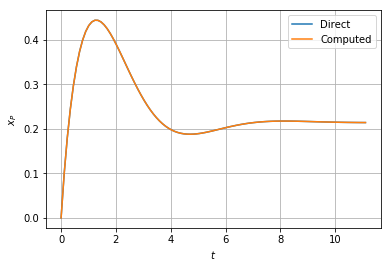

In [14]:

t_step = np.linspace(0,1000,100)
t_step = None
t_ss = 1e2

x_ss,v_ss,CL = ClosedLoop(Allosteric,chemostats,parameter,X0,t_ss,t_step,quiet=quiet)

CLL,L = LoopGain(Allosteric,chemostats,parameter,x_ss,quiet=quiet)

print('Closed-loop: direct')
showTF(CL)
print('Closed-loop: from loop-gain')
showTF(CLL)

## Find reduced-order systems using balanced reduction
print('Closed-loop: direct (reduced)')
showTF(con.tf(con.balred(con.tf2ss(CL),3)))
print('Closed-loop: from loop-gain (reduced)')
showTF(con.tf(con.balred(con.tf2ss(CLL),3)))

t_CL,y_CL = plotCL(CL,CLL,t_step)



### Discussion
Transfer function orders are reduced in two ways:

- Using con.minreal (minimal realisation) to cancel approximately identical poles and zeros (using tolerance tol). This is used each time a transfer function is extracted.
      
- Using con.balred (balanced reduction) to give a transfer function of given order.

In this case there are four transfer functions relating the product concentration $x_P$ to the  to the four flows
which add to drive the product concentration $x_P$ 

- $v_{r1}$ - the main feedback path. 
This is $\dfrac{s^2 + 1.995 s + 3.659}{s^2 + 3 s + 1}$

- This is the sum of two transfer functions:
    - an *active* path via the allosteric inhibition module: $\dfrac{3.659}{s^2 + 3 s + 1}$
    - a *passive* path via the admittance of the reaction chain at the product **Ce:P**: $\dfrac{s^2 + 1.995 s}{s^2 + 3 s + 1}$

- $v_{r2}$ - the product flow absorbed by  **Ce:B0**. This is the unit transfer function in this case.

- $5v_{re}$ and $5v_{ce}$ - the flow transiently absorbed by **Ce:EM** and  **Ce:CM**. With reference to the bode diagram, this is small and can be ignored.

The closed-loop transfer function relating the disturbance concentration $x_{B0}$ to product concentration $x_P$ can be derived in two ways: directly, and from the loop gain. When reduced to third order, the closed-loop transfer function is $\dfrac{0.9824 s^2 + 2.958 s + 0.9859}{s^3 + 4.978 s^2 + 5.925 s + 4.594}$. 

- This has a real pole at $s = - 3.7$ and a complex pair of poles at $s =  -0.631 \pm 0.915j$. This gives a stable but oscillatory response.

- the steady-state gain is $0.215$. Thus a unit disturbance gives a 21.5% change in product concentration, without feedback this would be 100%.

- The step response plot verifies this.

## Frequency response analysis

Bode diagram: loop gain components


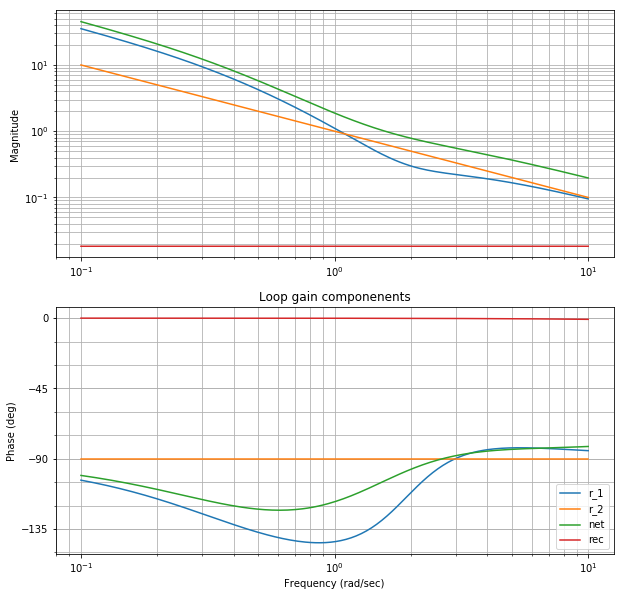

Bode diagram: Passive and active loop-gain components


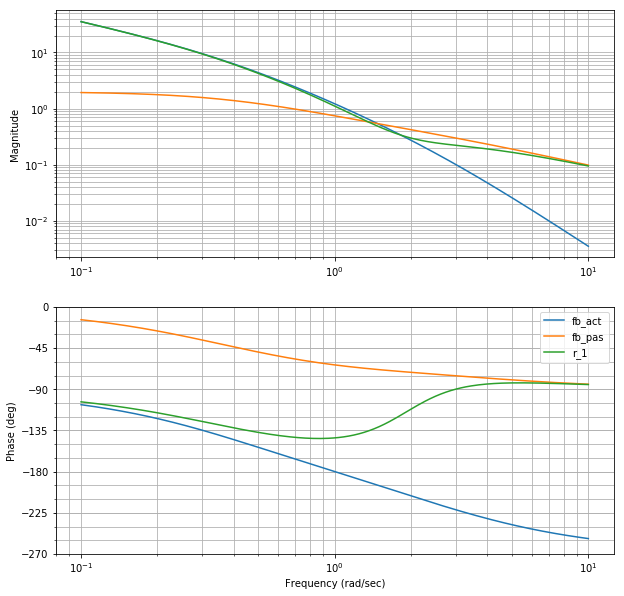

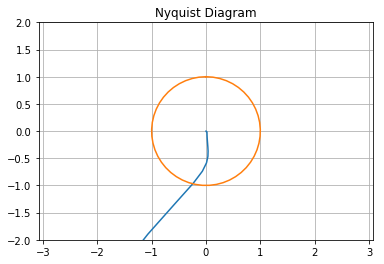

In [15]:
plotOL(L)

### Phase margins

In [16]:
gm, pm, wg, wp = con.margin(L['net'])
#print('Gain margin',gm)
print('Phase margin of loop-gain is',pm,'at omega =',wp)

# gm, pm, wg, wp = con.margin(L['fb_act'])
# print('Phase margin of fb_act is',pm,'at omega =',wp)

gm, pm, wg, wp = con.margin(con.parallel(L['fb_act'],L[r_last]))
print('Phase margin of fb_act+fb_r_last is',pm,'at omega =',wp)


Phase margin of loop-gain is 75.95006861540071 at omega = 1.581685736613151
Phase margin of fb_act+fb_r_last is 42.172473898898204 at omega = 1.2668858916825174


### Discussion

- A control systems discussion is needed here
- Active feedback dominates at low fequencies , and passive feedback at high frequencies.
- The active feedback reduces the effect of disturbances at low frequencies
- The passive feedback has no effect at zero frequency but has a phase advance effect at high frequencies thus improving phase margin and thence stability.
- even long reaction chains, which would be destabilised by the active feedback alone, are stabilised by the passive feedback.

## Compare linear and non-linear responses

Text(0.5,1,'Linear and normalised non-linear step responses')

Text(0.5,0,'$t$')

Text(0,0.5,'x_P/amp')

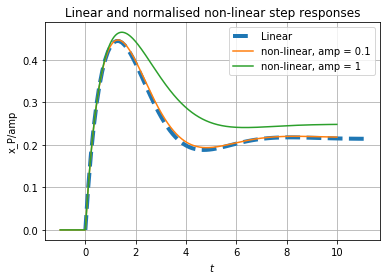

In [17]:
t_max = int(11)
t = np.linspace(0,t_max,1000)
t_0 = 1


AMP = [0.1,1]
Legend = ['Linear']
for amp in AMP:
    ## Chemostat
    x_B0 = x_ss[s['species'].index('B0')]
    x_chemo = '{0}*(1+{2}*np.heaviside(t-{1},1))'.format(str(x_B0),str(t_0),str(amp))
    x_chemo_lin = '{0}*(np.heaviside(t-{1},1))'.format(str(x_B0),str(t_0))
    X_chemo = {'B0':x_chemo}
    X_chemo_lin = {'B0':x_chemo}

    ## Non linear simulation (from steady state)
    ndat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=x_ss,X_chemo=X_chemo,quiet=quiet)
    i_P = s['species'].index('P')
    x_P = ndat['X'][:,i_P] - x_ss[i_P]
    if amp is AMP[0]:
        X_P = x_P/amp
    else:
        X_P = np.vstack((X_P,x_P/amp))
    Legend.append('non-linear, amp = '+str(amp))
                     
##Plot
plt.title('Linear and normalised non-linear step responses')
plt.plot(t_CL,y_CL,linewidth=4,linestyle='--')
plt.plot(t-t_0,X_P.T)
plt.xlabel('$t$')
plt.ylabel('x_P/amp')
plt.legend(Legend)
plt.grid()
plt.show()

### Discussion

The full non-linear simulation verifies that a disturbance step change of 

- 0.1 gives a close fit

- 1.0 gives a reasonable fit.